In [167]:
from pyhdf.SD import SD
import numpy
import pystare
import matplotlib.pyplot as plt
import scipy
import scipy.ndimage

## Mod09

In [168]:
import importlib
import sys
sys.path.insert(0,'../') 

In [169]:
import staremaster.products
importlib.reload(staremaster.products)

<module 'staremaster.products' from '/home/griessbaum/Dropbox/UCSB/STARE_Project/STAREMaster_py/examples/../staremaster/products/__init__.py'>

In [170]:
file_path = '/home/griessbaum/MOD09.A2019317.0815.006.2019319020759.hdf'
granule = staremaster.products.MOD09(file_path)

In [185]:
granule.read_gring()
granule.read_laton()

In [186]:
sids = staremaster.conversions.latlon2stare(granule.lats, 
                                            granule.lons, 
                                            n_workers=4)

In [187]:
cover_res = int(pystare.spatial_resolution(sids).max())
cover_sids = pystare.to_nonconvex_hull_range_from_latlon(granule.gring_lats,
                                                         granule.gring_lats,
                                                         cover_res)

In [906]:
# iterating over scan groups

lat_500 = []
lon_500 = []

for group_start in range(0, 2030, 10):
    group_lats = granule.lats[group_start:group_start+10]
    group_lons = granule.lons[group_start:group_start+10]    
    
    # Zoom out by factor (2n-1)/2; I.e. 2707/1354 in scan, 19/10 in track 
    lat_500_g = scipy.ndimage.zoom(group_lats, (19/10, 2707/1354), order=1)
    lon_500_g = scipy.ndimage.zoom(group_lons, (19/10,  2707/1354), order=1)
    
    # Calculate the gradient to 
    # a) shift 0.5 lenghts (250 m) in track direction and 1 length (500 m) in scan direction
    # b) Extrapolate the last observation in track direction
    # c) Extrapolate the last observation in scan direction
    
    gxx_lat, gyy_lat = numpy.gradient(lat_500_g)
    lat_500_g = lat_500_g - 0.5*gxx_lat - 1*gyy_lat    
    lat_final_x = lat_500_g[-1] + 1*gxx_lat[-1]         # Last track of group
    lat_500_g = numpy.append(lat_500_g, [lat_final_x], axis=0)
    
    gxx_lon, gyy_lon = numpy.gradient(lon_500_g)
    lon_500_g = lon_500_g - 0.5*gxx_lon - 1*gyy_lon
    lon_final_x = lon_500_g[-1] + 1*gxx_lon[-1]          # Last track of group
    lon_500_g  = numpy.append(lon_500_g, [lon_final_x], axis=0) 
    
    lat_final_y = lat_500_g[:, -1] + numpy.gradient(lat_500_g)[1][:, -1] # Last scan
    lat_500_g = numpy.append(lat_500_g.T, [lat_final_y], axis=0).T
    
    lon_final_y = lon_500_g[:, -1] + numpy.gradient(lon_500_g)[1][:, -1] # Last scan
    lon_500_g = numpy.append(lon_500_g.T, [lon_final_y], axis=0).T
            
    lat_500.append(lat_500_g)
    lon_500.append(lon_500_g)
    
lat_500 = numpy.concatenate(lat_500)
lon_500 = numpy.concatenate(lon_500)

In [835]:
sids = staremaster.conversions.latlon2stare(lat_500, 
                                            lon_500, 
                                            n_workers=4)

# Verification Plots

<AxesSubplot:>

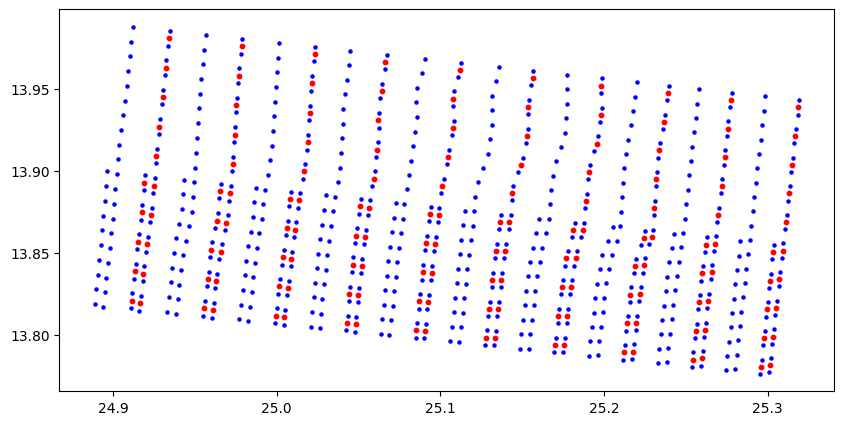

In [907]:
fig = plt.figure(figsize=(10, 10), dpi=100)
ax = fig.add_subplot()

df = geopandas.GeoDataFrame(geometry=geopandas.points_from_xy(granule.lons[0:15, 0:10].flatten(), 
                                                              granule.lats[0:15, 0:10].flatten()))

df2 = geopandas.GeoDataFrame(geometry=geopandas.points_from_xy(lon_500[0:30, 0:20].flatten(), 
                                                               lat_500[0:30, 0:20].flatten()))

df.plot(ax=ax, color='red', markersize=10)
df2.plot(ax=ax,markersize=5, color='blue')

<AxesSubplot:>

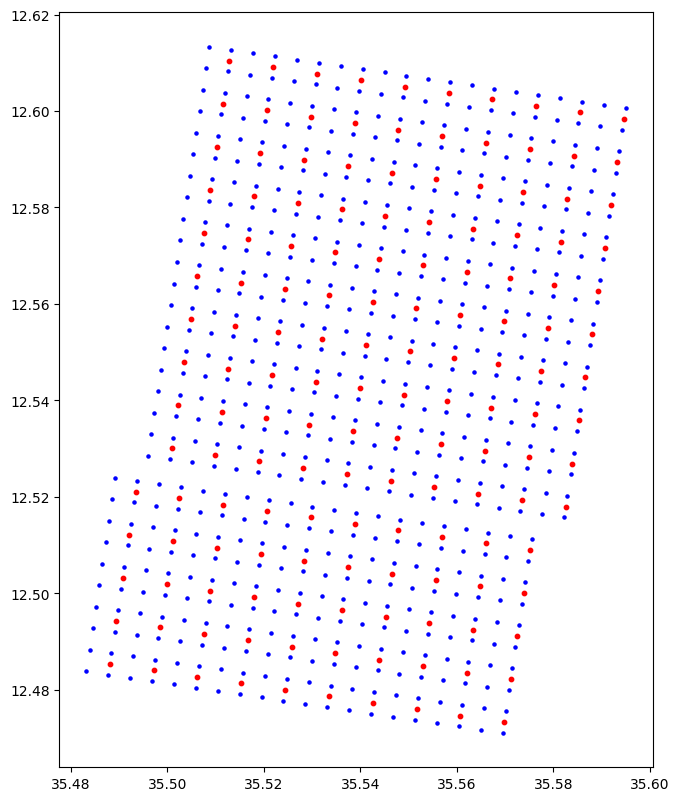

In [908]:
fig = plt.figure(figsize=(10, 10), dpi=100)
ax = fig.add_subplot()

df = geopandas.GeoDataFrame(geometry=geopandas.points_from_xy(granule.lons[0:15, 670:680].flatten(), 
                                                              granule.lats[0:15, 670:680].flatten()))

df2 = geopandas.GeoDataFrame(geometry=geopandas.points_from_xy(lon_500[0:30, 1340:1360].flatten(), 
                                                               lat_500[0:30, 1340:1360].flatten()))

df.plot(ax=ax, color='red', markersize=10)
df2.plot(ax=ax,markersize=5, color='blue')

<AxesSubplot:>

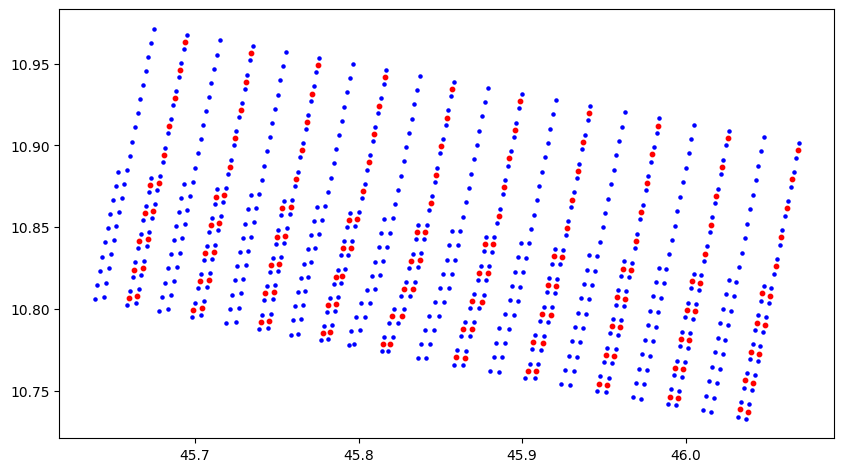

In [909]:
fig = plt.figure(figsize=(10, 10), dpi=100)
ax = fig.add_subplot()

df = geopandas.GeoDataFrame(geometry=geopandas.points_from_xy(granule.lons[0:15, -10:].flatten(), 
                                                              granule.lats[0:15, -10:].flatten()))

df2 = geopandas.GeoDataFrame(geometry=geopandas.points_from_xy(lon_500[0:30, -20:].flatten(), 
                                                               lat_500[0:30, -20:].flatten()))

df.plot(ax=ax, color='red', markersize=10)
df2.plot(ax=ax,markersize=5, color='blue')